In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np

# Load ML-ready dataset
df = pd.read_csv(r"/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_with_blosum62.csv")
print(df.shape)
df.head()

(809642, 21)


,variationid,gene,chr,pos,ref,alt,name,clinicalsignificance,rsid,label,...,protein_change,ref_aa,pos_aa,alt_aa,blosum62_raw,hydropathy_diff,is_stop,allele_freq,ref_parsed,alt_parsed
0,3,AP5Z1,7,4827361,na,na,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),Pathogenic,397704709,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,3,AP5Z1,7,4787730,na,na,NM_014855.3(AP5Z1):c.1413_1426del (p.Leu473fs),Pathogenic,397704709,1,...,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,5,FOXRED1,11,126145284,C,T,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),Pathogenic,267606829,1,...,p.Gln232Ter,Q,232.0,*,NaN,3.5,1,0.000008,C,T
3,5,FOXRED1,11,126275389,C,T,NM_017547.4(FOXRED1):c.694C>T (p.Gln232Ter),Pathogenic,267606829,1,...,p.Gln232Ter,Q,232.0,*,NaN,3.5,1,NaN,C,T
4,14,HFE,6,26093236,G,A,NM_000410.4(HFE):c.892+48G>A,Benign,1800758,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0.134000,G,A


In [2]:
X = df.drop(columns=["label"])
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (647713, 20) Test: (161929, 20)


In [4]:
# --- FIX LABEL COLUMNS CLEANLY ---
import pandas as pd

df = pd.read_csv("/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_with_blosum62.csv")

# 1. Drop the BROKEN label_numeric column
df = df.drop(columns=["label_numeric"], errors="ignore")

# 2. Rename the correct numeric label
df = df.rename(columns={"label": "label_numeric"})

# 3. Create a proper text label column for plotting
df["label"] = df["label_numeric"].map({1: "pathogenic", 0: "benign"})

print(df[["label_numeric","label"]].head(10))

# Save fixed version
df.to_csv("/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_fixed_labels_real.csv", index=False)
print("Saved fixed file → clinvar_fixed_labels_real.csv")

   label_numeric       label
0              1  pathogenic
1              1  pathogenic
2              1  pathogenic
3              1  pathogenic
4              0      benign
5              0      benign
6              1  pathogenic
7              1  pathogenic
8              1  pathogenic
9              1  pathogenic
Saved fixed file → clinvar_fixed_labels_real.csv


In [4]:
# create_label_numeric_for_given_file.ipynb cell
import pandas as pd
import numpy as np
from pathlib import Path
import os, textwrap


CSV_PATH = Path(r"/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_fixed_labels_real.csv")

# ---------- Sanity checks ----------
print("Checking file:", CSV_PATH)
if not CSV_PATH.exists():
    raise FileNotFoundError(f"File not found: {CSV_PATH}. Please check the path.")

# ---------- Load ----------
print("Loading CSV (this may take a moment)...")
df = pd.read_csv(CSV_PATH, low_memory=False)
print("Loaded shape:", df.shape)
print()

# ---------- Find candidate label column ----------
candidates = [c for c in df.columns if c.lower() in ("label","label_numeric","clinicalsignificance","clinical_significance","clinical significance","clinical_sig","clinical_significance")]
if not candidates:
    # broader search
    candidates = [c for c in df.columns if ("label" in c.lower()) or ("clinical" in c.lower())]
print("Label-like candidate columns found:", candidates)

if not candidates:
    print("No label-like column found. Please tell me which column contains the ClinVar label text (e.g. 'label' or 'clinicalsignificance').")
else:
    # use the first candidate
    label_col = candidates[0]
    print("Using label column:", label_col)
    # show top unique values
    print("\nTop unique values (raw) in that column:")
    try:
        vc = df[label_col].astype(str).str.strip().value_counts(dropna=False)
        display(vc.head(200))
    except Exception as e:
        print("Could not print value counts:", e)

    # ---------- Normalize & map ----------
    def normalize_label(s):
        if pd.isna(s):
            return ""
        s2 = str(s).strip().lower()
        # unify common separators and punctuation to underscores
        for ch in [",","/",";","|"," - ", " -", "- ", " "]:
            s2 = s2.replace(ch, "_")
        s2 = s2.replace("__","_")
        s2 = s2.strip("_")
        return s2

    # define explicit mapping (normalized form -> numeric)
    explicit_map = {
        "pathogenic": 1,
        "likely_pathogenic": 1,
        "pathogenic_likely_pathogenic": 1,
        "pathogenic,_likely_pathogenic": 1,
        "likely_pathogenic_pathogenic": 1,
        "benign": 0,
        "likely_benign": 0,
        "benign_likely_benign": 0,
        "benign,_likely_benign": 0,
        "likely_benign_benign": 0,
    }

    # normalize column and map
    df["_label_norm"] = df[label_col].apply(normalize_label)

    def map_norm_to_numeric(norm_s):
        if norm_s is None:
            return np.nan
        if norm_s in explicit_map:
            return explicit_map[norm_s]
        # heuristics: substring matching
        if "pathogenic" in norm_s and "benign" not in norm_s:
            return 1
        if "benign" in norm_s and "pathogenic" not in norm_s:
            return 0
        # treat numeric strings "0" or "1"
        if norm_s in ("0","1"):
            return int(norm_s)
        # VUS / uncertain / conflicting -> NaN (do not train on these)
        if any(x in norm_s for x in ("uncertain","vus","conflict","conflicting","not_provided","no assertion")):
            return np.nan
        # fallback: if empty
        if norm_s == "":
            return np.nan
        # last attempt: try numeric conversion
        try:
            val = float(norm_s)
            if val in (0.0,1.0):
                return int(val)
        except:
            pass
        return np.nan

    df["label_numeric"] = df["_label_norm"].apply(map_norm_to_numeric).astype("Float64")

    # If label_numeric still empty, try converting original column to numeric
    if df["label_numeric"].notna().sum() == 0:
        try:
            df["label_numeric"] = pd.to_numeric(df[label_col], errors="coerce").astype("Float64")
        except Exception:
            pass

    # ---------- Diagnostics ----------
    print("\nMapping results (label_numeric counts):")
    print(df["label_numeric"].value_counts(dropna=False))

    n_total = len(df)
    n_labeled = int(df["label_numeric"].notna().sum())
    n_pos = int(df["label_numeric"].fillna(0).sum()) if n_labeled>0 else 0
    print(f"\nTotal rows: {n_total}; Labeled rows (0/1): {n_labeled}; Positives (1): {n_pos}; Fraction labeled: {n_labeled/n_total:.3f}")

    # Show ambiguous examples (NaN)
    ambiguous = df[df["label_numeric"].isna()][label_col].astype(str).value_counts().head(20)
    print("\nTop ambiguous/NaN label strings (will be excluded from training):")
    display(ambiguous)

    # show a few row examples for manual inspection
    print("\nSample ambiguous rows (first 10):")
    display(df.loc[df["label_numeric"].isna(), [label_col, "_label_norm"]].head(10))

    # ---------- Save updated CSV ----------
    out_path = CSV_PATH.with_name(CSV_PATH.stem + "_labelnumeric.csv")
    df.to_csv(out_path, index=False)
    print("\nSaved updated CSV with 'label_numeric' to:", out_path)
    print("\nIf you want to force 'likely_pathogenic' -> pathogenic (or map specific strings), tell me which strings from the ambiguous list should be mapped to 1 or 0, and I will update the mapping and re-run.")


Checking file: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_fixed_labels_real.csv
Loading CSV (this may take a moment)...
Loaded shape: (809642, 22)

Label-like candidate columns found: ['clinicalsignificance', 'label_numeric', 'label']
Using label column: clinicalsignificance

Top unique values (raw) in that column:


clinicalsignificance
Benign                                 422468
Pathogenic                             386745
Pathogenic; other                         156
Pathogenic; drug response                  81
Pathogenic; risk factor                    47
Benign; risk factor                        38
Benign; other                              26
Benign; association                        22
Pathogenic; Affects                        16
Benign; drug response                      11
Benign; protective                          8
Pathogenic; association                     8
Benign; Affects                             6
Pathogenic; protective                      4
Benign; confers sensitivity                 2
Pathogenic; confers sensitivity             2
Benign; Affects; association; other         2
Name: count, dtype: int64


Mapping results (label_numeric counts):
label_numeric
0.0    422583
1.0    387059
Name: count, dtype: Int64

Total rows: 809642; Labeled rows (0/1): 809642; Positives (1): 387059; Fraction labeled: 1.000

Top ambiguous/NaN label strings (will be excluded from training):


Series([], Name: count, dtype: int64)


Sample ambiguous rows (first 10):


,clinicalsignificance,_label_norm



Saved updated CSV with 'label_numeric' to: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_fixed_labels_real_labelnumeric.csv

If you want to force 'likely_pathogenic' -> pathogenic (or map specific strings), tell me which strings from the ambiguous list should be mapped to 1 or 0, and I will update the mapping and re-run.


In [2]:
# Feature engineering cell
# Adds: grantham_distance, allele_freq filling, log_af, clinvar review parsing
# Optionally: Pfam domain membership (if you provide pfam_map CSV)
# Optionally: conservation scores from bigWig via pyBigWig (if you provide path)
# Saves output to clinvar_features_engineered.csv

import pandas as pd
import numpy as np
from pathlib import Path
import os

# ---------- CONFIG ----------
INPUT_CSV = Path(r"/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_fixed_labels_real_labelnumeric.csv")
OUT_CSV = INPUT_CSV.with_name("clinvar_features_engineered.csv")

# Optional: Pfam mapping file (tab/tsv) with columns: gene, pfam_start, pfam_end, pfam_name
# If you have a file mapping gene -> protein domain ranges, set PFAM_MAP_PATH, else set None.
PFAM_MAP_PATH = None
# Example: Path("data/processed/pfam_gene_domains.tsv")

# Optional: conservation bigWig (phastCons / phyloP). If you have a bigWig covering the genome,
# set BIGWIG_PATH to that file. Must be indexed bigWig. Requires pyBigWig installed.
BIGWIG_PATH = None
# Example: Path("/data/phastCons46way.bw")

# ---------- Helper: Grantham distance table ----------
# Grantham distances between amino acids (classic 20x20). Source: Grantham 1974.
AA_ORDER = list("ARNDCQEGHILKMFPSTWYV")  # standard order (used below only for mapping)
GRANTHAM = {
    # mapping dictionary (symmetric). We'll provide full explicit table for reliability:
    ('A','A'):0, ('A','R'):112, ('A','N'):111, ('A','D'):126, ('A','C'):195, ('A','Q'):91, ('A','E'):107, ('A','G'):60, ('A','H'):86, ('A','I'):94, ('A','L'):96, ('A','K'):106, ('A','M'):84, ('A','F'):113, ('A','P'):27, ('A','S'):99, ('A','T'):58, ('A','W'):148, ('A','Y'):112, ('A','V'):64,
    ('R','A'):112, ('R','R'):0, ('R','N'):86, ('R','D'):96, ('R','C'):180, ('R','Q'):43, ('R','E'):54, ('R','G'):125, ('R','H'):29, ('R','I'):97, ('R','L'):102, ('R','K'):26, ('R','M'):91, ('R','F'):97, ('R','P'):103, ('R','S'):110, ('R','T'):71, ('R','W'):101, ('R','Y'):77, ('R','V'):96,
    ('N','A'):111, ('N','R'):86, ('N','N'):0, ('N','D'):23, ('N','C'):139, ('N','Q'):46, ('N','E'):42, ('N','G'):80, ('N','H'):68, ('N','I'):149, ('N','L'):153, ('N','K'):94, ('N','M'):142, ('N','F'):158, ('N','P'):91, ('N','S'):46, ('N','T'):65, ('N','W'):174, ('N','Y'):143, ('N','V'):133,
    ('D','A'):126, ('D','R'):96, ('D','N'):23, ('D','D'):0, ('D','C'):154, ('D','Q'):61, ('D','E'):45, ('D','G'):94, ('D','H'):81, ('D','I'):168, ('D','L'):172, ('D','K'):101, ('D','M'):160, ('D','F'):177, ('D','P'):108, ('D','S'):65, ('D','T'):85, ('D','W'):181, ('D','Y'):160, ('D','V'):152,
    ('C','A'):195, ('C','R'):180, ('C','N'):139, ('C','D'):154, ('C','C'):0, ('C','Q'):154, ('C','E'):170, ('C','G'):159, ('C','H'):174, ('C','I'):198, ('C','L'):198, ('C','K'):202, ('C','M'):196, ('C','F'):205, ('C','P'):169, ('C','S'):112, ('C','T'):149, ('C','W'):215, ('C','Y'):194, ('C','V'):192,
    ('Q','A'):91, ('Q','R'):43, ('Q','N'):46, ('Q','D'):61, ('Q','C'):154, ('Q','Q'):0, ('Q','E'):29, ('Q','G'):87, ('Q','H'):24, ('Q','I'):109, ('Q','L'):113, ('Q','K'):53, ('Q','M'):101, ('Q','F'):130, ('Q','P'):76, ('Q','S'):68, ('Q','T'):42, ('Q','W'):130, ('Q','Y'):99, ('Q','V'):96,
    ('E','A'):107, ('E','R'):54, ('E','N'):42, ('E','D'):45, ('E','C'):170, ('E','Q'):29, ('E','E'):0, ('E','G'):98, ('E','H'):40, ('E','I'):134, ('E','L'):138, ('E','K'):56, ('E','M'):126, ('E','F'):140, ('E','P'):93, ('E','S'):80, ('E','T'):65, ('E','W'):152, ('E','Y'):122, ('E','V'):121,
    ('G','A'):60, ('G','R'):125, ('G','N'):80, ('G','D'):94, ('G','C'):159, ('G','Q'):87, ('G','E'):98, ('G','G'):0, ('G','H'):98, ('G','I'):135, ('G','L'):138, ('G','K'):127, ('G','M'):127, ('G','F'):153, ('G','P'):42, ('G','S'):56, ('G','T'):59, ('G','W'):184, ('G','Y'):147, ('G','V'):109,
    ('H','A'):86, ('H','R'):29, ('H','N'):68, ('H','D'):81, ('H','C'):174, ('H','Q'):24, ('H','E'):40, ('H','G'):98, ('H','H'):0, ('H','I'):94, ('H','L'):99, ('H','K'):32, ('H','M'):87, ('H','F'):100, ('H','P'):77, ('H','S'):89, ('H','T'):47, ('H','W'):115, ('H','Y'):83, ('H','V'):84,
    ('I','A'):94, ('I','R'):97, ('I','N'):149, ('I','D'):168, ('I','C'):198, ('I','Q'):109, ('I','E'):134, ('I','G'):135, ('I','H'):94, ('I','I'):0, ('I','L'):5, ('I','K'):102, ('I','M'):10, ('I','F'):21, ('I','P'):95, ('I','S'):142, ('I','T'):89, ('I','W'):61, ('I','Y'):33, ('I','V'):29,
    ('L','A'):96, ('L','R'):102, ('L','N'):153, ('L','D'):172, ('L','C'):198, ('L','Q'):113, ('L','E'):138, ('L','G'):138, ('L','H'):99, ('L','I'):5, ('L','L'):0, ('L','K'):107, ('L','M'):15, ('L','F'):22, ('L','P'):98, ('L','S'):145, ('L','T'):92, ('L','W'):61, ('L','Y'):36, ('L','V'):32,
    ('K','A'):106, ('K','R'):26, ('K','N'):94, ('K','D'):101, ('K','C'):202, ('K','Q'):53, ('K','E'):56, ('K','G'):127, ('K','H'):32, ('K','I'):102, ('K','L'):107, ('K','K'):0, ('K','M'):95, ('K','F'):102, ('K','P'):103, ('K','S'):121, ('K','T'):78, ('K','W'):110, ('K','Y'):85, ('K','V'):97,
    ('M','A'):84, ('M','R'):91, ('M','N'):142, ('M','D'):160, ('M','C'):196, ('M','Q'):101, ('M','E'):126, ('M','G'):127, ('M','H'):87, ('M','I'):10, ('M','L'):15, ('M','K'):95, ('M','M'):0, ('M','F'):28, ('M','P'):87, ('M','S'):135, ('M','T'):81, ('M','W'):67, ('M','Y'):36, ('M','V'):21,
    ('F','A'):113, ('F','R'):97, ('F','N'):158, ('F','D'):177, ('F','C'):205, ('F','Q'):130, ('F','E'):140, ('F','G'):153, ('F','H'):100, ('F','I'):21, ('F','L'):22, ('F','K'):102, ('F','M'):28, ('F','F'):0, ('F','P'):114, ('F','S'):155, ('F','T'):103, ('F','W'):40, ('F','Y'):22, ('F','V'):50,
    ('P','A'):27, ('P','R'):103, ('P','N'):91, ('P','D'):108, ('P','C'):169, ('P','Q'):76, ('P','E'):93, ('P','G'):42, ('P','H'):77, ('P','I'):95, ('P','L'):98, ('P','K'):103, ('P','M'):87, ('P','F'):114, ('P','P'):0, ('P','S'):74, ('P','T'):38, ('P','W'):147, ('P','Y'):110, ('P','V'):68,
    ('S','A'):99, ('S','R'):110, ('S','N'):46, ('S','D'):65, ('S','C'):112, ('S','Q'):68, ('S','E'):80, ('S','G'):56, ('S','H'):89, ('S','I'):142, ('S','L'):145, ('S','K'):121, ('S','M'):135, ('S','F'):155, ('S','P'):74, ('S','S'):0, ('S','T'):58, ('S','W'):177, ('S','Y'):144, ('S','V'):124,
    ('T','A'):58, ('T','R'):71, ('T','N'):65, ('T','D'):85, ('T','C'):149, ('T','Q'):42, ('T','E'):65, ('T','G'):59, ('T','H'):47, ('T','I'):89, ('T','L'):92, ('T','K'):78, ('T','M'):81, ('T','F'):103, ('T','P'):38, ('T','S'):58, ('T','T'):0, ('T','W'):128, ('T','Y'):92, ('T','V'):69,
    ('W','A'):148, ('W','R'):101, ('W','N'):174, ('W','D'):181, ('W','C'):215, ('W','Q'):130, ('W','E'):152, ('W','G'):184, ('W','H'):115, ('W','I'):61, ('W','L'):61, ('W','K'):110, ('W','M'):67, ('W','F'):40, ('W','P'):147, ('W','S'):177, ('W','T'):128, ('W','W'):0, ('W','Y'):37, ('W','V'):88,
    ('Y','A'):112, ('Y','R'):77, ('Y','N'):143, ('Y','D'):160, ('Y','C'):194, ('Y','Q'):99, ('Y','E'):122, ('Y','G'):147, ('Y','H'):83, ('Y','I'):33, ('Y','L'):36, ('Y','K'):85, ('Y','M'):36, ('Y','F'):22, ('Y','P'):110, ('Y','S'):144, ('Y','T'):92, ('Y','W'):37, ('Y','Y'):0, ('Y','V'):96,
    ('V','A'):64, ('V','R'):96, ('V','N'):133, ('V','D'):152, ('V','C'):192, ('V','Q'):96, ('V','E'):121, ('V','G'):109, ('V','H'):84, ('V','I'):29, ('V','L'):32, ('V','K'):97, ('V','M'):21, ('V','F'):50, ('V','P'):68, ('V','S'):124, ('V','T'):69, ('V','W'):88, ('V','Y'):96, ('V','V'):0
}

# symmetric lookup
def grantham_lookup(a, b):
    if pd.isna(a) or pd.isna(b):
        return np.nan
    a = str(a).upper()
    b = str(b).upper()
    if len(a) != 1 or len(b) != 1:
        return np.nan
    if (a,b) in GRANTHAM:
        return GRANTHAM[(a,b)]
    if (b,a) in GRANTHAM:
        return GRANTHAM[(b,a)]
    return np.nan

# ---------- Load input ----------
if not INPUT_CSV.exists():
    raise FileNotFoundError(f"Input CSV not found: {INPUT_CSV}")
print("Loading", INPUT_CSV)
df = pd.read_csv(INPUT_CSV, low_memory=False)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

# ---------- 1) Grantham distance ----------
print("Computing Grantham distance (ref_aa, alt_aa)...")
if ("ref_aa" in df.columns) and ("alt_aa" in df.columns):
    df["grantham"] = df.apply(lambda r: grantham_lookup(r["ref_aa"], r["alt_aa"]), axis=1)
    print("Non-null grantham:", int(df["grantham"].notna().sum()))
else:
    df["grantham"] = np.nan
    print("ref_aa / alt_aa not found - grantham set to NaN.")

# ---------- 2) Allele frequency filling & transforms ----------
print("Filling allele frequency fields...")
af_cols = [c for c in ("allele_freq","af","gnomad_af","af_filled","af_raw") if c in df.columns]
if "allele_freq" in df.columns:
    # use allele_freq as canonical
    df["af_filled"] = df["allele_freq"].fillna(0.0)
else:
    # attempt to pick any candidate column
    found = None
    for c in ("af_filled","af","gnomad_af","af_raw"):
        if c in df.columns:
            found = c
            break
    if found:
        df["allele_freq"] = df[found]
        df["af_filled"] = df[found].fillna(0.0)
        print("Used", found, "as allele_freq.")
    else:
        # no AF info
        df["allele_freq"] = np.nan
        df["af_filled"] = 0.0
        print("No allele frequency columns found. af_filled set to 0.0 (you may want to update with gnomAD later).")

# safe clip to [0,1]
df["af_filled"] = pd.to_numeric(df["af_filled"], errors="coerce").fillna(0.0).clip(lower=0.0, upper=1.0)
# log transform (small epsilon)
df["log_af"] = np.log10(df["af_filled"] + 1e-12)

# ---------- 3) ClinVar review / clinical significance normalization ----------
print("Normalizing clinical significance / review fields...")
# clinicalsignificance fields often named 'clinicalsignificance' or 'clinical_significance' or 'label'
label_col = None
for c in df.columns:
    if c.lower() in ("clinicalsignificance","clinical_significance","clinical_significance_comment","clinicalsig"):
        label_col = c
        break
if label_col is None:
    # fallback to 'label' or 'clinical_significance'
    for c in ("label","clinical_significance","clinical_sig"):
        if c in df.columns:
            label_col = c
            break

if label_col:
    print("Using column for clinical label:", label_col)
    df["clinvar_label_raw"] = df[label_col].astype(str)
    # normalize to compact categories
    def norm_clinvar_label(s):
        if pd.isna(s): return ""
        s2 = str(s).strip().lower()
        # simple checks
        if "pathogenic" in s2 and "benign" not in s2:
            return "pathogenic"
        if "benign" in s2 and "pathogenic" not in s2:
            return "benign"
        if "likely_pathogenic" in s2 or "likely pathogenic" in s2:
            return "likely_pathogenic"
        if "likely_benign" in s2 or "likely benign" in s2:
            return "likely_benign"
        if "uncertain" in s2 or "vus" in s2:
            return "uncertain_significance"
        if "conflict" in s2:
            return "conflicting_interpretations"
        return s2
    df["clinvar_label_norm"] = df["clinvar_label_raw"].apply(norm_clinvar_label)
    # create a numeric label if not present
    if "label_numeric" not in df.columns or df["label_numeric"].isna().all():
        df["label_numeric"] = df["clinvar_label_norm"].map({"pathogenic":1, "likely_pathogenic":1, "benign":0, "likely_benign":0})
else:
    print("No clinicalsignificance/label-like column found. Skipping clinvar_label_norm.")
    df["clinvar_label_raw"] = ""
    df["clinvar_label_norm"] = ""
    if "label_numeric" not in df.columns:
        df["label_numeric"] = np.nan

# ---------- 4) Pfam / protein domain membership (optional) ----------
if PFAM_MAP_PATH is not None and Path(PFAM_MAP_PATH).exists():
    print("Loading Pfam mapping from:", PFAM_MAP_PATH)
    pf = pd.read_csv(PFAM_MAP_PATH, sep=None, engine="python", low_memory=False)
    # expect columns: gene, pfam_start, pfam_end, pfam_name (try to detect)
    expected = ["gene","pfam_start","pfam_end"]
    if not all(e in pf.columns for e in expected):
        print("Pfam file loaded but missing expected columns. Skipping Pfam mapping.")
    else:
        # ensure numeric positions
        pf["pfam_start"] = pd.to_numeric(pf["pfam_start"], errors="coerce")
        pf["pfam_end"] = pd.to_numeric(pf["pfam_end"], errors="coerce")
        # create mapping: for each variant, check if pos_aa falls within any pfam range for that gene
        def map_pfam(row):
            gene = row.get("gene")
            pos = row.get("pos_aa")
            if pd.isna(gene) or pd.isna(pos):
                return ""
            gene_pf = pf[pf["gene"].astype(str)==str(gene)]
            if gene_pf.empty:
                return ""
            hits = gene_pf[(gene_pf["pfam_start"]<=pos) & (gene_pf["pfam_end"]>=pos)]
            if len(hits)>0:
                # return semi-colon separated pfam names
                return ";".join(map(str, hits["pfam_name"].fillna("pfam")))
            return ""
        df["pfam_domains"] = df.apply(map_pfam, axis=1)
        print("Pfam mapping added: pfam_domains column (string). Non-empty count:", int(df["pfam_domains"].astype(bool).sum()))
else:
    print("Pfam mapping not provided or not found. Skipping Pfam feature. To enable, set PFAM_MAP_PATH to a TSV with gene,pfam_start,pfam_end,pfam_name.")

# ---------- 5) Conservation: check existing columns or optional bigWig (phastCons / phyloP) ----------
conserv_cols = [c for c in ("phastcons","phastcons46way","phastcons100way","phylop","phyloP") if c in df.columns]
if conserv_cols:
    print("Found conservation columns:", conserv_cols)
    # normalize to unified name if possible
    df["conservation_score"] = df[conserv_cols[0]]
else:
    # optional bigWig support if user set BIGWIG_PATH and pyBigWig installed
    if BIGWIG_PATH is not None and Path(BIGWIG_PATH).exists():
        try:
            import pyBigWig
            bw = pyBigWig.open(str(BIGWIG_PATH))
            # requires df contains 'chr' (like '1' or 'chr1') and 'pos' (genomic coordinate)
            if ("chr" in df.columns) and ("pos" in df.columns):
                def fetch_bw_score(r):
                    ch = str(r["chr"])
                    if not str(ch).startswith("chr"):
                        ch = "chr"+ch
                    pos = int(r["pos"])
                    # bigWig is 0-based half-open, fetch single base
                    try:
                        vals = bw.values(ch, pos-1, pos)
                        return float(vals[0]) if vals and vals[0] is not None else np.nan
                    except Exception:
                        return np.nan
                print("Querying bigWig for conservation scores (this may be slow)...")
                df["conservation_score"] = df.apply(fetch_bw_score, axis=1)
                bw.close()
                print("Conservation scores added. Non-null count:", int(df["conservation_score"].notna().sum()))
            else:
                print("No chr/pos columns available to lookup bigWig. Skipping bigWig conservation lookup.")
        except Exception as e:
            print("pyBigWig not available or bigWig lookup failed:", e)
            df["conservation_score"] = np.nan
    else:
        print("No conservation columns and no BIGWIG_PATH provided. Skipping conservation. If you have phastCons/phyloP bigWig files, set BIGWIG_PATH to the file path and install pyBigWig.")

# ---------- 6) Quick sanity & stats ----------
print("\nFeature engineering summary:")
new_cols = ["grantham","af_filled","log_af","clinvar_label_norm","label_numeric","pfam_domains","conservation_score"]
present_new = [c for c in new_cols if c in df.columns]
for c in present_new:
    nonnull = int(df[c].notna().sum())
    print(f"  {c:20s}: present, non-null = {nonnull}")

# show small sample
print("\nSample of engineered features (first 10 rows):")
display(df.loc[:, ["variationid","gene","chr","pos","ref","alt","ref_aa","alt_aa"] + [c for c in present_new if c in df.columns]].head(10))

# Save
df.to_csv(OUT_CSV, index=False)
print("\nSaved engineered CSV to:", OUT_CSV)


Loading /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_fixed_labels_real_labelnumeric.csv
Rows: 809642
Columns: ['variationid', 'gene', 'chr', 'pos', 'ref', 'alt', 'name', 'clinicalsignificance', 'rsid', 'label_numeric', 'cdna', 'protein_change', 'ref_aa', 'pos_aa', 'alt_aa', 'blosum62_raw', 'hydropathy_diff', 'is_stop', 'allele_freq', 'ref_parsed', 'alt_parsed', 'label', '_label_norm']
Computing Grantham distance (ref_aa, alt_aa)...
Non-null grantham: 109152
Filling allele frequency fields...
Normalizing clinical significance / review fields...
Using column for clinical label: clinicalsignificance
Pfam mapping not provided or not found. Skipping Pfam feature. To enable, set PFAM_MAP_PATH to a TSV with gene,pfam_start,pfam_end,pfam_name.
No conservation columns and no BIGWIG_PATH provided. Skipping conservation. If you have phastCons/phyloP bigWig files, set BIGWIG_PATH to the file path and install pyBigWig.

Feature engineering summary:
  grantham            : p

,variationid,gene,chr,pos,ref,alt,ref_aa,alt_aa,grantham,af_filled,log_af,clinvar_label_norm,label_numeric
0,3,AP5Z1,7,4827361,na,na,NaN,NaN,NaN,0.000000,-12.000000,pathogenic,1.0
1,3,AP5Z1,7,4787730,na,na,NaN,NaN,NaN,0.000000,-12.000000,pathogenic,1.0
2,5,FOXRED1,11,126145284,C,T,Q,*,NaN,0.000008,-5.084073,pathogenic,1.0
3,5,FOXRED1,11,126275389,C,T,Q,*,NaN,0.000000,-12.000000,pathogenic,1.0
4,14,HFE,6,26093236,G,A,NaN,NaN,NaN,0.134000,-0.872895,benign,0.0
5,14,HFE,6,26093008,G,A,NaN,NaN,NaN,0.000000,-12.000000,benign,0.0
6,18,HFE,6,26093443,G,T,R,M,91.0,0.000000,-12.000000,pathogenic,1.0
7,18,HFE,6,26093215,G,T,R,M,91.0,0.000000,-12.000000,pathogenic,1.0
8,20,WDR35,2,20189045,A,G,NaN,NaN,NaN,0.000000,-12.000000,pathogenic,1.0
9,20,WDR35,2,19989284,A,G,NaN,NaN,NaN,0.000000,-12.000000,pathogenic,1.0



Saved engineered CSV to: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv


Loading: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv
shape: (809642, 28)
Features used: ['blosum62_raw', 'grantham', 'hydropathy_diff', 'is_stop', 'af_filled', 'log_af']
Rows with full features+label: 109152 / 809642
Train/test: (87321, 6) (21831, 6)
Test label dist:


label_numeric
0    12267
1     9564
Name: count, dtype: int64


Training Logistic Regression...
Saved LogisticRegression
Training RandomForest...
Saved RandomForest
Training XGBoost...
Saved XGBoost

Evaluating LogisticRegression ...
LogisticRegression: acc=0.660, prec=0.602, rec=0.663, f1=0.631, auc=0.7381752452924522

Evaluating RandomForest ...


/home/mygenome/.local/share/mamba/envs/varpred/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


RandomForest: acc=0.714, prec=0.658, rec=0.723, f1=0.689, auc=0.7933339812959233

Evaluating XGBoost ...
XGBoost: acc=0.717, prec=0.684, rec=0.657, f1=0.670, auc=0.7940318409259854
Saved: results/ml/pretty_plots/roc_pretty.png


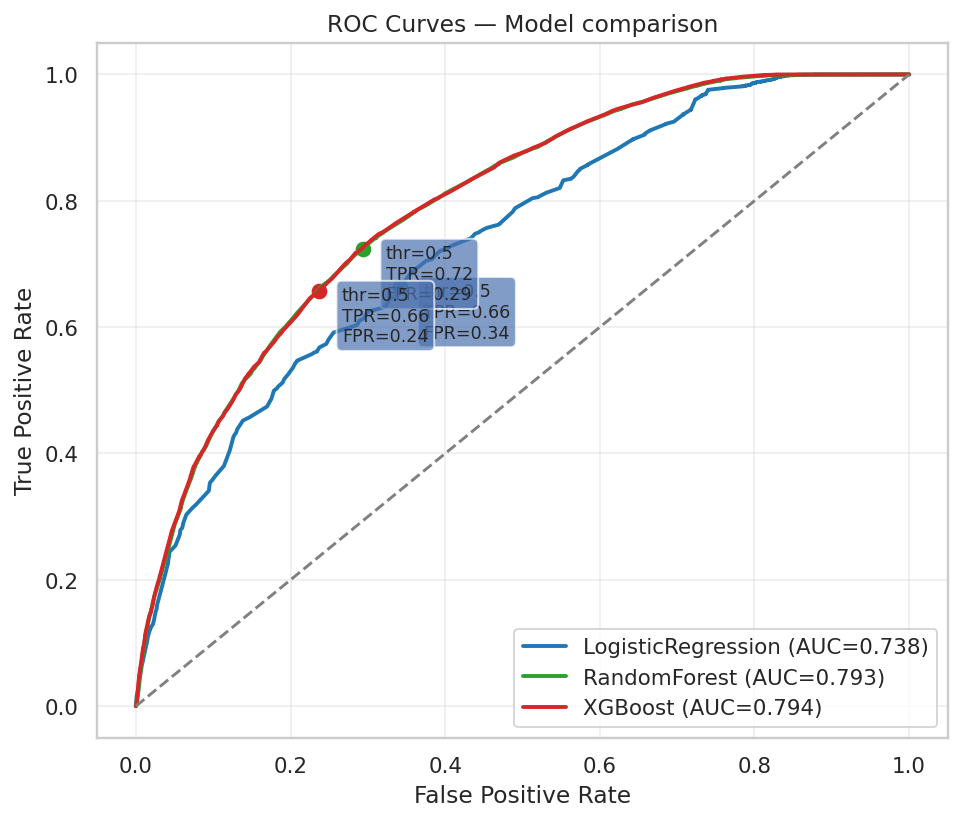

Saved: results/ml/pretty_plots/cm_LogisticRegression.png


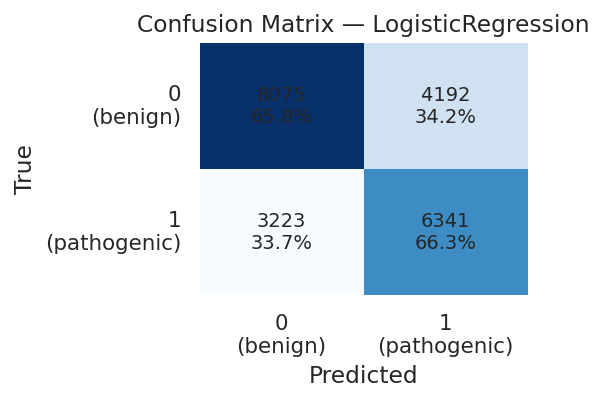

Saved: results/ml/pretty_plots/cm_RandomForest.png


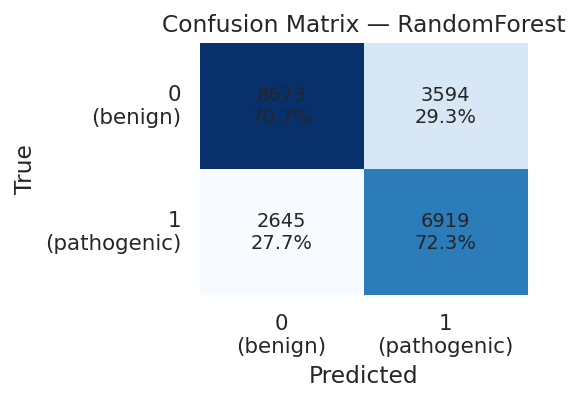

Saved: results/ml/pretty_plots/cm_XGBoost.png


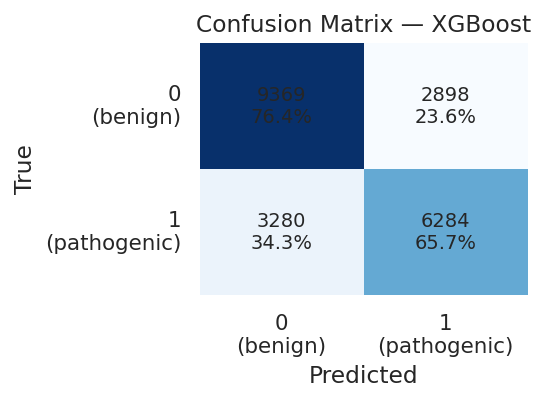

Saved: results/ml/pretty_plots/feat_imp_lr_signed.png


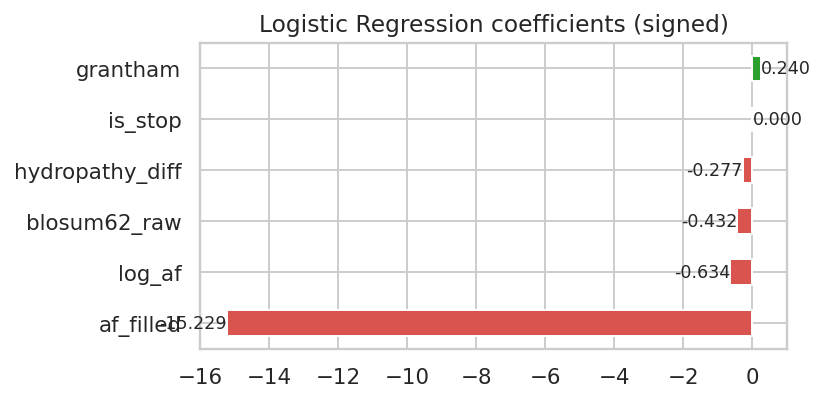

Saved: results/ml/pretty_plots/feat_imp_lr_abs.png


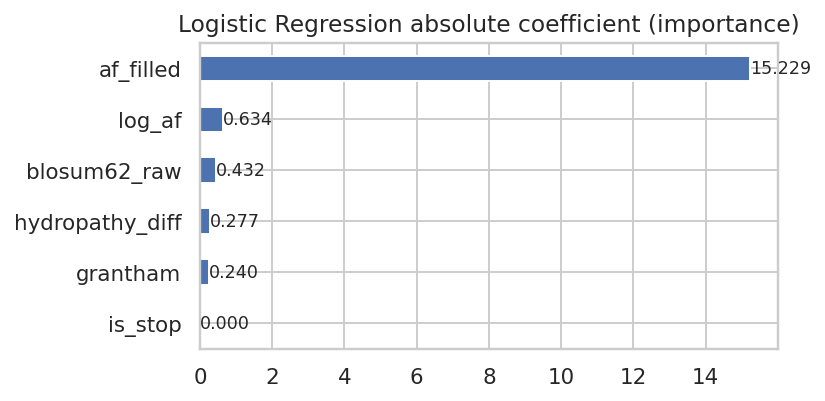

Saved: results/ml/pretty_plots/feat_imp_rf.png


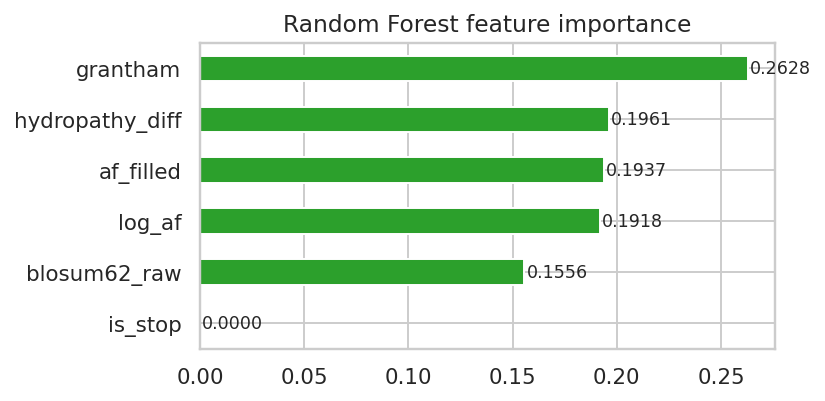

Saved: results/ml/pretty_plots/feat_imp_xgb.png


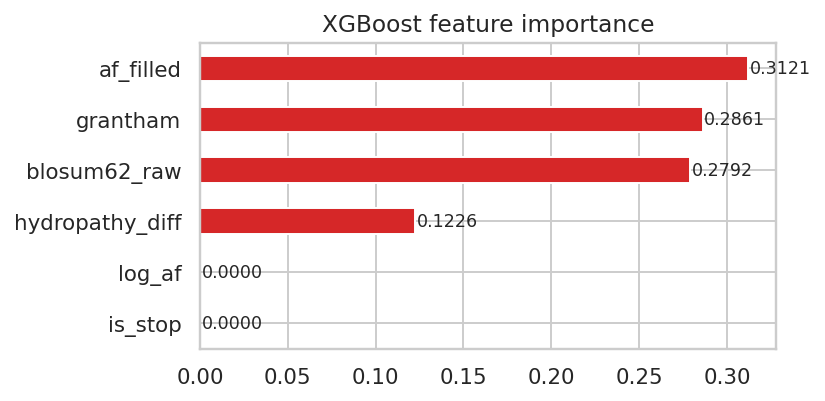


Model comparison:


,accuracy,precision,recall,f1,roc_auc
model,,,,,
LogisticRegression,0.660,0.602,0.663,0.631,0.738
RandomForest,0.714,0.658,0.723,0.689,0.793
XGBoost,0.717,0.684,0.657,0.670,0.794


Saved summary CSV to: results/ml/pretty_plots/model_comparison_pretty.csv


In [8]:
# Fixed pretty evaluation cell (LR, RF, XGBoost) — CONFUSION MATRIX TICK FIXED
import os, sys, traceback, math, joblib
from pathlib import Path
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score)
sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi":140, "font.size":11})

# ---------- CONFIG ----------
CSV = Path(r"/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv")
OUT_DIR = Path("results") / "ml" / "pretty_plots"
MODELS_DIR = Path("results") / "ml" / "models"
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RND = 42
SAMPLE_N = None   # set integer to downsample for speed

FEATURE_CANDIDATES = ["blosum62_raw","grantham","hydropathy_diff","is_stop","af_filled","log_af","conservation_score"]

# ---------- Helpers ----------
def try_import_xgboost(install_if_missing=True):
    try:
        import xgboost as xgb
        return xgb
    except Exception:
        if install_if_missing:
            print("xgboost not present — attempting pip install (may take a moment)...")
            try:
                import subprocess, sys
                subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "xgboost"])
            except Exception as e:
                print("pip install xgboost failed:", e)
            try:
                import importlib
                importlib.invalidate_caches()
                import xgboost as xgb
                return xgb
            except Exception as e:
                print("xgboost still unavailable:", e)
                return None
        return None

def pretty_save(fig, path):
    fig.tight_layout()
    fig.savefig(path, dpi=150, bbox_inches="tight")
    print("Saved:", path)

def annotate_barh(ax, fmt="{:.3f}", xpad=0.005):
    for p in ax.patches:
        width = p.get_width()
        y = p.get_y() + p.get_height()/2
        ax.text(width + xpad, y, fmt.format(width), va="center", fontsize=9)

def plot_confusion_matrix_neat(cm, labels=("benign","pathogenic"), title=None, cmap="Blues", figsize=(4,3)):
    # cm: 2x2 confusion matrix
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt="d", cmap=cmap, cbar=False, ax=ax)
    # percent by true-class (row)
    with np.errstate(invalid='ignore', divide='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_pct = cm.astype(float) / row_sums
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cnt = int(cm[i,j])
            pct = cm_pct[i,j] * 100 if row_sums[i,0] != 0 else 0.0
            ax.text(j + 0.5, i + 0.5, f"{cnt}\n{pct:.1f}%", ha='center', va='center', fontsize=10)
    # set explicit tick positions and labels (fixes mismatch bug)
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels([f"0\n({labels[0]})", f"1\n({labels[1]})"], rotation=0)
    ax.set_yticklabels([f"0\n({labels[0]})", f"1\n({labels[1]})"], rotation=0)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    if title:
        ax.set_title(title)
    return fig, ax

# ---------- Main ----------
try:
    # load data
    if not CSV.exists():
        raise FileNotFoundError(f"CSV not found: {CSV}")
    print("Loading:", CSV)
    df = pd.read_csv(CSV, low_memory=False)
    print("shape:", df.shape)

    # choose features present
    features = [c for c in FEATURE_CANDIDATES if c in df.columns]
    if not features:
        raise RuntimeError("No expected features found. Available columns: " + ", ".join(df.columns[:50].tolist()))
    print("Features used:", features)

    # prepare label
    if "label_numeric" not in df.columns:
        raise RuntimeError("label_numeric missing. Run label mapping step first.")
    y = pd.to_numeric(df["label_numeric"], errors="coerce")
    X = df[features].copy()
    for c in X.columns:
        X[c] = pd.to_numeric(X[c], errors="coerce")
    mask = X.notna().all(axis=1) & (~y.isna())
    print(f"Rows with full features+label: {int(mask.sum())} / {len(df)}")
    if int(mask.sum()) < 50:
        raise RuntimeError("Too few rows (<50) with complete features+label to evaluate.")

    X = X.loc[mask].reset_index(drop=True)
    y = y.loc[mask].astype(int).reset_index(drop=True)

    # optional sampling
    if SAMPLE_N is not None and len(X) > SAMPLE_N:
        X = X.sample(n=SAMPLE_N, random_state=RND).reset_index(drop=True)
        y = y.loc[X.index].reset_index(drop=True)
        print("Sampled to:", len(X))

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RND)
    print("Train/test:", X_train.shape, X_test.shape)
    print("Test label dist:")
    display(pd.Series(y_test).value_counts())

    # scale for LR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, MODELS_DIR / "scaler.pkl")

    # train LR
    print("\nTraining Logistic Regression...")
    lr = LogisticRegression(class_weight="balanced", max_iter=2000, random_state=RND)
    lr.fit(X_train_scaled, y_train)
    joblib.dump(lr, MODELS_DIR / "logistic_regression.pkl")
    print("Saved LogisticRegression")

    # train RF
    print("Training RandomForest...")
    rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", n_jobs=-1, random_state=RND)
    rf.fit(X_train, y_train)
    joblib.dump(rf, MODELS_DIR / "random_forest.pkl")
    print("Saved RandomForest")

    # train XGBoost (attempt install if needed)
    xgb = try_import_xgboost(install_if_missing=True)
    xgb_clf = None
    if xgb is not None:
        try:
            print("Training XGBoost...")
            xgb_clf = xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, use_label_encoder=False, verbosity=0, random_state=RND)
            xgb_clf.fit(X_train.values, y_train.values)
            joblib.dump(xgb_clf, MODELS_DIR / "xgboost.pkl")
            print("Saved XGBoost")
        except Exception as e:
            print("XGBoost training failed:", e)
            xgb_clf = None
    else:
        print("XGBoost not available; LR and RF only.")

    # collect models
    models = {"LogisticRegression": (lr, True), "RandomForest": (rf, False)}
    if xgb_clf is not None:
        models["XGBoost"] = (xgb_clf, False)

    # evaluate
    results = {}
    for name, (model, needs_scaled) in models.items():
        print(f"\nEvaluating {name} ...")
        Xte = X_test_scaled if needs_scaled else X_test.values
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(Xte)[:,1]
        else:
            if hasattr(model, "decision_function"):
                from scipy.special import expit
                probs = expit(model.decision_function(Xte))
            else:
                probs = model.predict(Xte).astype(float)
        preds = (probs >= 0.5).astype(int)
        cm = confusion_matrix(y_test, preds)
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, zero_division=0)
        rec = recall_score(y_test, preds, zero_division=0)
        f1 = f1_score(y_test, preds, zero_division=0)
        auc = roc_auc_score(y_test, probs) if len(np.unique(y_test))>1 else np.nan
        results[name] = {"model":model, "needs_scaled":needs_scaled, "probs":probs, "preds":preds, "cm":cm, "acc":acc, "prec":prec, "rec":rec, "f1":f1, "auc":auc}
        print(f"{name}: acc={acc:.3f}, prec={prec:.3f}, rec={rec:.3f}, f1={f1:.3f}, auc={(auc if not math.isnan(auc) else 'N/A')}")

    # ROC plot
    roc_path = OUT_DIR / "roc_pretty.png"
    if len(np.unique(y_test)) > 1:
        fig, ax = plt.subplots(figsize=(7,6))
        palette = {"LogisticRegression":"#1f77b4","RandomForest":"#2ca02c","XGBoost":"#d62728"}
        for name, info in results.items():
            try:
                fpr, tpr, thr = roc_curve(y_test, info["probs"])
                ax.plot(fpr, tpr, label=f"{name} (AUC={info['auc']:.3f})", color=palette.get(name,None), linewidth=2)
                # annotate thr=0.5
                idx = np.argmin(np.abs(thr - 0.5))
                if idx < len(fpr):
                    ax.scatter(fpr[idx], tpr[idx], s=50, color=palette.get(name,None))
                    ax.annotate(f"thr=0.5\nTPR={tpr[idx]:.2f}\nFPR={fpr[idx]:.2f}", xy=(fpr[idx], tpr[idx]), xytext=(fpr[idx]+0.03, tpr[idx]-0.08),
                                bbox=dict(boxstyle="round,pad=0.3", alpha=0.7), fontsize=9)
            except Exception as e:
                print("Skipping ROC for", name, "due to:", e)
        ax.plot([0,1],[0,1], "--", color="gray")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("ROC Curves — Model comparison")
        ax.legend(loc="lower right")
        ax.grid(alpha=0.3)
        pretty_save(fig, roc_path)
        plt.show()
    else:
        print("ROC skipped: test set contains only one class; cannot compute ROC/AUC.")

    # confusion matrices neat
    for name, info in results.items():
        cm = info["cm"]
        fig, ax = plot_confusion_matrix_neat(cm, labels=("benign","pathogenic"), title=f"Confusion Matrix — {name}", figsize=(4,3))
        cm_path = OUT_DIR / f"cm_{name}.png"
        pretty_save(fig, cm_path)
        plt.show()

    # feature importances
    feat_names = features

    # LR signed + abs
    if "LogisticRegression" in results:
        model = results["LogisticRegression"]["model"]
        coef = model.coef_.ravel()
        sr = pd.Series(coef, index=feat_names).sort_values()
        fig, ax = plt.subplots(figsize=(6, max(3, 0.4*len(sr))))
        colors = ["#d9534f" if v<0 else "#2ca02c" for v in sr.values]
        sr.plot(kind="barh", ax=ax, color=colors)
        ax.set_title("Logistic Regression coefficients (signed)")
        for i, v in enumerate(sr.values):
            ax.text(v + (0.001 if v>=0 else -0.001), i, f"{v:.3f}", va="center", ha=("left" if v>=0 else "right"), fontsize=9)
        p = OUT_DIR / "feat_imp_lr_signed.png"
        pretty_save(fig, p)
        plt.show()

        abs_sr = sr.abs().sort_values()
        fig, ax = plt.subplots(figsize=(6, max(3, 0.4*len(abs_sr))))
        abs_sr.plot(kind="barh", ax=ax, color="#4c72b0")
        ax.set_title("Logistic Regression absolute coefficient (importance)")
        annotate_barh(ax, fmt="{:.3f}", xpad=0.002)
        p = OUT_DIR / "feat_imp_lr_abs.png"
        pretty_save(fig, p)
        plt.show()

    # RF importances
    if "RandomForest" in results:
        model = results["RandomForest"]["model"]
        imp = pd.Series(model.feature_importances_, index=feat_names).sort_values()
        fig, ax = plt.subplots(figsize=(6, max(3, 0.4*len(imp))))
        imp.plot(kind="barh", ax=ax, color="#2ca02c")
        ax.set_title("Random Forest feature importance")
        annotate_barh(ax, fmt="{:.4f}", xpad=0.001)
        p = OUT_DIR / "feat_imp_rf.png"
        pretty_save(fig, p)
        plt.show()

    # XGBoost importances
    if "XGBoost" in results:
        try:
            model = results["XGBoost"]["model"]
            imp = pd.Series(model.feature_importances_, index=feat_names).sort_values()
            fig, ax = plt.subplots(figsize=(6, max(3, 0.4*len(imp))))
            imp.plot(kind="barh", ax=ax, color="#d62728")
            ax.set_title("XGBoost feature importance")
            annotate_barh(ax, fmt="{:.4f}", xpad=0.001)
            p = OUT_DIR / "feat_imp_xgb.png"
            pretty_save(fig, p)
            plt.show()
        except Exception as e:
            print("Could not plot XGBoost importances:", e)

    # final summary
    rows = []
    for name, info in results.items():
        rows.append({
            "model": name,
            "accuracy": round(info["acc"],3),
            "precision": round(info["prec"],3),
            "recall": round(info["rec"],3),
            "f1": round(info["f1"],3),
            "roc_auc": (round(info["auc"],3) if (info["auc"] is not None and not math.isnan(info["auc"])) else None)
        })
    summary = pd.DataFrame(rows).set_index("model")
    print("\nModel comparison:")
    display(summary)
    summary.to_csv(OUT_DIR / "model_comparison_pretty.csv")
    print("Saved summary CSV to:", OUT_DIR / "model_comparison_pretty.csv")

except Exception as e:
    print("An error occurred — full traceback below:")
    traceback.print_exc()
    raise


Loading CSV: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv
shape: (809642, 28)
Features: ['blosum62_raw', 'grantham', 'hydropathy_diff', 'is_stop', 'af_filled', 'log_af']
Rows with complete features+label: 109152
Train/test: (87321, 6) (21831, 6)
Test class counts:


label_numeric
0    12267
1     9564
Name: count, dtype: int64


Training Logistic Regression...
Training Random Forest...
Training XGBoost (no early stopping to avoid API mismatch)...
LogisticRegression -> acc:0.660 prec:0.602 rec:0.663 f1:0.631 AUC:0.7381752452924522 AP:0.681
RandomForest -> acc:0.714 prec:0.658 rec:0.723 f1:0.689 AUC:0.7933339812959233 AP:0.728
XGBoost -> acc:0.717 prec:0.684 rec:0.657 f1:0.670 AUC:0.7940318409259854 AP:0.731
Saved: results/ml/final_eval/models_roc.png


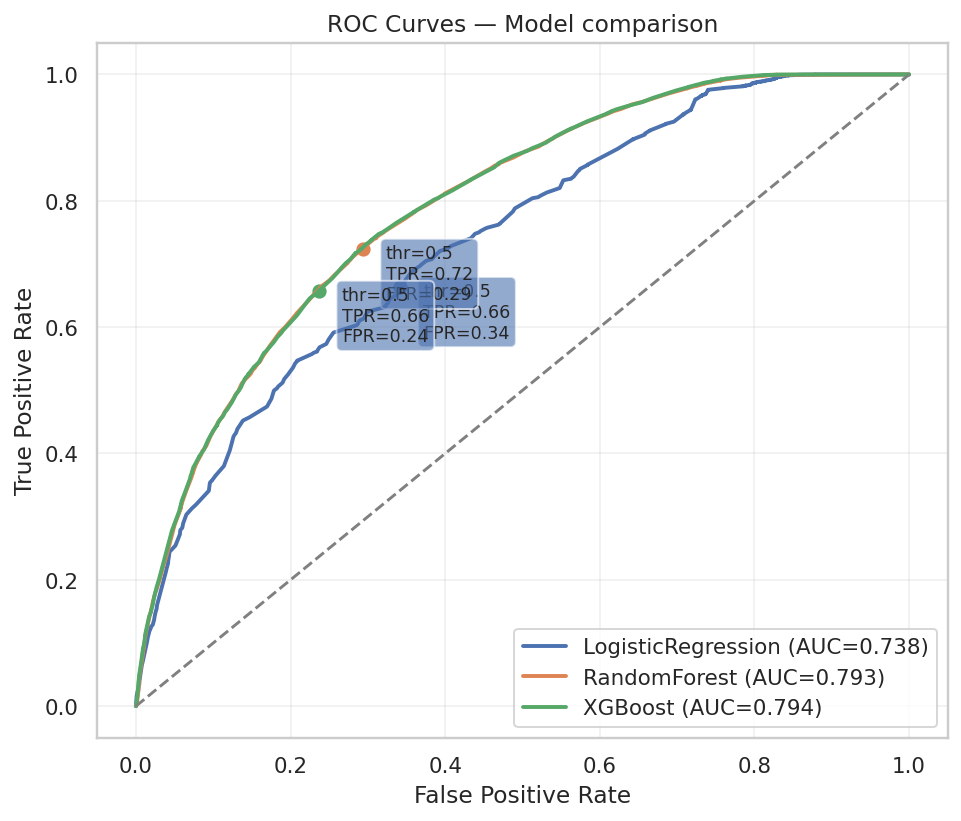

Saved: results/ml/final_eval/models_pr.png


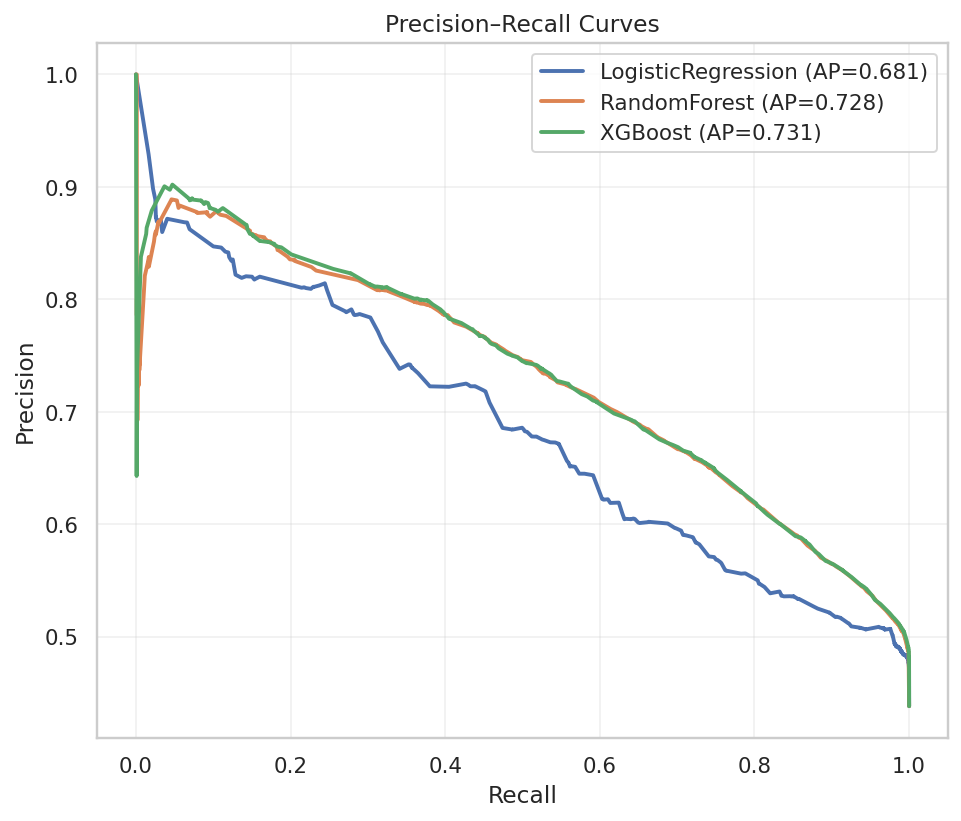

Saved: results/ml/final_eval/cm_LogisticRegression.png


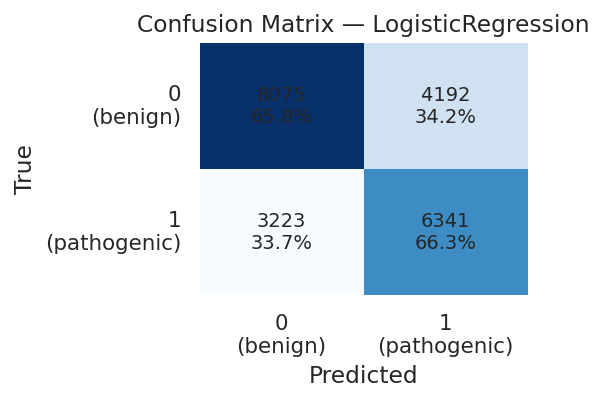

Saved: results/ml/final_eval/cm_RandomForest.png


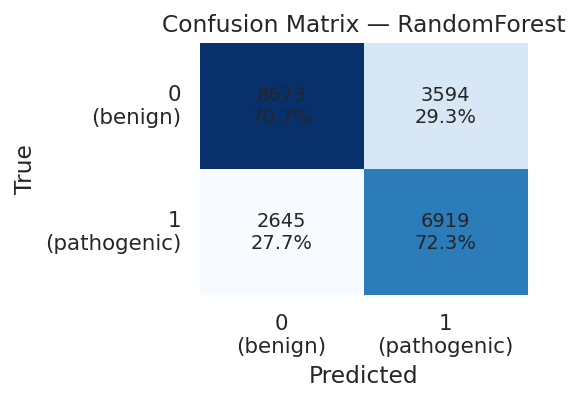

Saved: results/ml/final_eval/cm_XGBoost.png


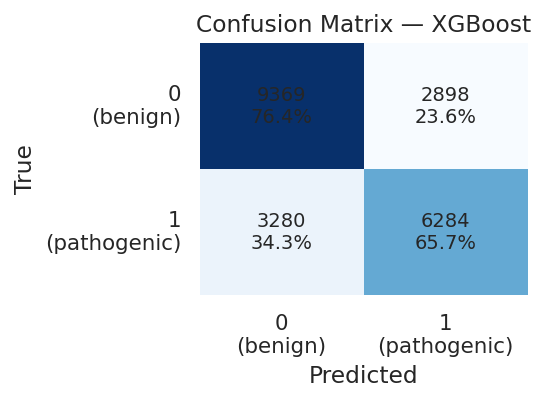

Saved: results/ml/final_eval/feat_imp_lr_signed.png


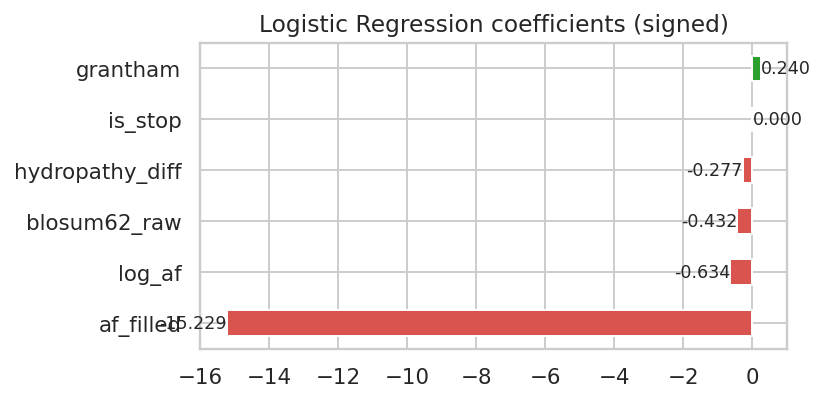

Saved: results/ml/final_eval/feat_imp_lr_abs.png


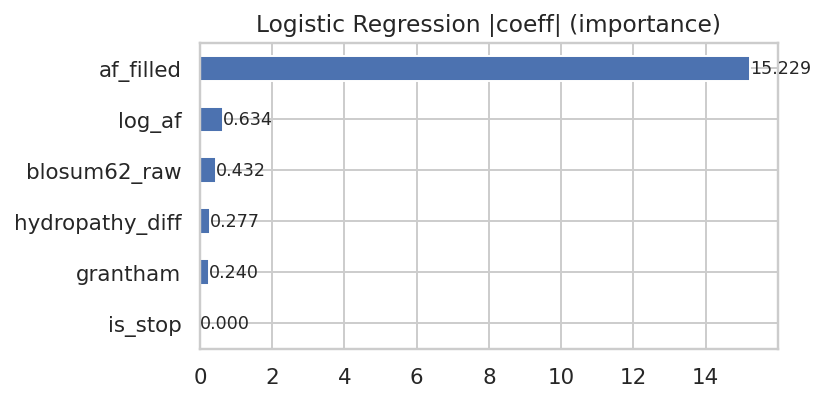

Saved: results/ml/final_eval/feat_imp_rf.png


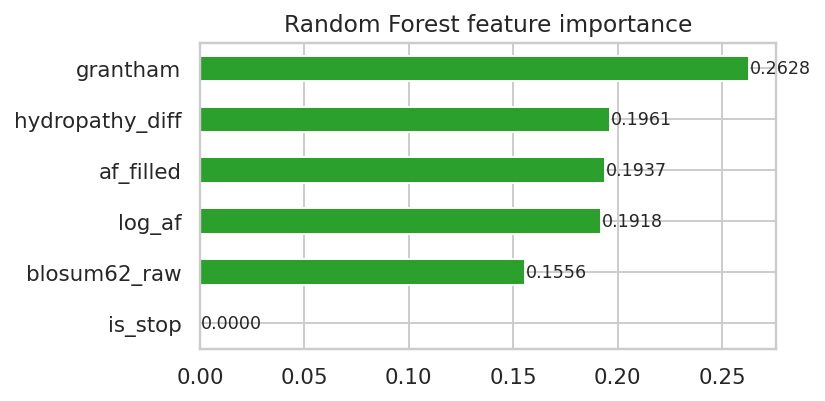

Saved: results/ml/final_eval/feat_imp_xgb.png


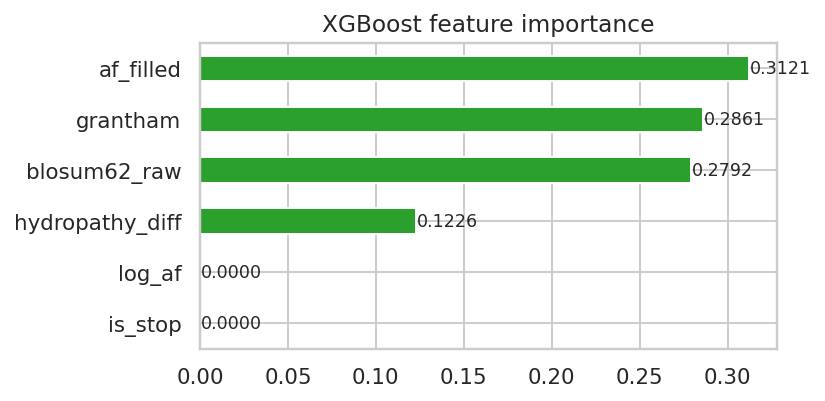

,accuracy,precision,recall,f1,roc_auc,avg_precision
model,,,,,,
LogisticRegression,0.6603,0.6020,0.6630,0.6310,0.7382,0.6811
RandomForest,0.7142,0.6581,0.7234,0.6892,0.7933,0.7282
XGBoost,0.7170,0.6844,0.6570,0.6704,0.7940,0.7306


Saved metrics CSV to: results/ml/final_eval/metrics_table.csv
All plots & metrics saved to: /home/mygenome/results/ml/final_eval


In [9]:
# Final professional ML evaluation cell (ROC, PR, Confusion Matrix, Metrics table, Feature importance)
import warnings, traceback, math, joblib, subprocess, sys
from pathlib import Path
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_curve, roc_auc_score, precision_recall_curve, average_precision_score,
                             confusion_matrix, accuracy_score, precision_score, recall_score, f1_score)
sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi":140, "font.size":11})
warnings.filterwarnings("ignore")

# ---------- CONFIG ----------
CSV = Path(r"/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv")
OUT = Path("results") / "ml" / "final_eval"
MODELS_DIR = OUT / "models"
OUT.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)
RND = 42
SAMPLE_N = None   # set e.g. 50000 to downsample for speed, or None to use all rows

FEATURE_CANDIDATES = ["blosum62_raw","grantham","hydropathy_diff","is_stop","af_filled","log_af","conservation_score"]

# ---------- Helpers ----------
def try_install_xgboost():
    try:
        import xgboost as xgb
        return xgb
    except Exception:
        print("xgboost not found — attempting pip install (may take a bit)...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "xgboost"])
        except Exception as e:
            print("pip install failed:", e)
            return None
        try:
            import importlib
            importlib.invalidate_caches()
            import xgboost as xgb
            return xgb
        except Exception as e:
            print("xgboost still unavailable:", e)
            return None

def save_fig(fig, p):
    fig.tight_layout()
    fig.savefig(p, dpi=150, bbox_inches="tight")
    print("Saved:", p)

def plot_roc_pr(all_results, y_test, out_prefix):
    # ROC
    if len(np.unique(y_test)) > 1:
        fig, ax = plt.subplots(figsize=(7,6))
        for name, r in all_results.items():
            fpr, tpr, thr = roc_curve(y_test, r["probs"])
            auc = r["roc_auc"]
            ax.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})", linewidth=2)
            # annotate thr ~ 0.5 if present
            if thr.size:
                idx = np.argmin(np.abs(thr - 0.5))
                if idx < len(fpr):
                    ax.scatter(fpr[idx], tpr[idx], s=40)
                    ax.annotate(f"thr=0.5\nTPR={tpr[idx]:.2f}\nFPR={fpr[idx]:.2f}",
                                xy=(fpr[idx], tpr[idx]),
                                xytext=(fpr[idx]+0.03, tpr[idx]-0.08),
                                bbox=dict(boxstyle="round,pad=0.3", alpha=0.6),
                                fontsize=9)
        ax.plot([0,1],[0,1], "--", color="gray")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.set_title("ROC Curves — Model comparison")
        ax.legend(loc="lower right")
        ax.grid(alpha=0.25)
        save_fig(fig, OUT / f"{out_prefix}_roc.png")
        plt.show()
    else:
        print("ROC skipped: only one class present in test set.")

    # PR curve
    fig, ax = plt.subplots(figsize=(7,6))
    for name, r in all_results.items():
        precision, recall, thr_pr = precision_recall_curve(y_test, r["probs"])
        ap = r["avg_prec"]
        ax.plot(recall, precision, label=f"{name} (AP={ap:.3f})", linewidth=2)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title("Precision–Recall Curves")
    ax.legend(loc="upper right")
    ax.grid(alpha=0.25)
    save_fig(fig, OUT / f"{out_prefix}_pr.png")
    plt.show()

def plot_confusion(cm, title, outpath):
    # neat confusion matrix: counts + row %
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cm, cmap="Blues", cbar=False, annot=False, ax=ax)
    # row percentages
    with np.errstate(invalid='ignore', divide='ignore'):
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_pct = cm.astype(float) / row_sums
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            cnt = int(cm[i,j])
            pct = cm_pct[i,j]*100 if row_sums[i,0] != 0 else 0.0
            ax.text(j + 0.5, i + 0.5, f"{cnt}\n{pct:.1f}%", ha="center", va="center", fontsize=10)
    # explicit ticks for 2x2
    ax.set_xticks([0.5, 1.5])
    ax.set_yticks([0.5, 1.5])
    ax.set_xticklabels(["0\n(benign)", "1\n(pathogenic)"], rotation=0)
    ax.set_yticklabels(["0\n(benign)", "1\n(pathogenic)"], rotation=0)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    save_fig(fig, outpath)
    plt.show()

def plot_feature_importance_lr(coefs, feat_names, outpath_signed, outpath_abs):
    s = pd.Series(coefs, index=feat_names).sort_values()
    # signed
    fig, ax = plt.subplots(figsize=(6, max(3, 0.4*len(s))))
    colors = ["#d9534f" if v < 0 else "#2ca02c" for v in s.values]
    s.plot(kind="barh", ax=ax, color=colors)
    ax.set_title("Logistic Regression coefficients (signed)")
    for i, v in enumerate(s.values):
        ha = "left" if v >= 0 else "right"
        x = v + (0.001 if v >= 0 else -0.001)
        ax.text(x, i, f"{v:.3f}", va="center", ha=ha, fontsize=9)
    save_fig(fig, outpath_signed)
    plt.show()
    # absolute
    a = s.abs().sort_values()
    fig, ax = plt.subplots(figsize=(6, max(3, 0.4*len(a))))
    a.plot(kind="barh", ax=ax, color="#4c72b0")
    ax.set_title("Logistic Regression |coeff| (importance)")
    for p in ax.patches:
        ax.text(p.get_width() + 0.002, p.get_y() + p.get_height()/2, f"{p.get_width():.3f}", va="center", fontsize=9)
    save_fig(fig, outpath_abs)
    plt.show()

def plot_feature_importance_tree(importances, feat_names, outpath, title="Feature importance"):
    s = pd.Series(importances, index=feat_names).sort_values()
    fig, ax = plt.subplots(figsize=(6, max(3, 0.4*len(s))))
    s.plot(kind="barh", ax=ax, color="#2ca02c")
    ax.set_title(title)
    for p in ax.patches:
        ax.text(p.get_width() + 0.0005, p.get_y() + p.get_height()/2, f"{p.get_width():.4f}", va="center", fontsize=9)
    save_fig(fig, outpath)
    plt.show()

# ---------- Run ----------
try:
    if not CSV.exists():
        raise FileNotFoundError(f"CSV not found: {CSV}")
    print("Loading CSV:", CSV)
    df = pd.read_csv(CSV, low_memory=False)
    print("shape:", df.shape)

    # select features existing in the CSV
    features = [c for c in FEATURE_CANDIDATES if c in df.columns]
    if len(features) == 0:
        raise RuntimeError("No candidate features found in CSV. Columns: " + ", ".join(df.columns[:50].tolist()))
    print("Features:", features)

    if "label_numeric" not in df.columns:
        raise RuntimeError("label_numeric missing. Run label mapping.")
    y_raw = pd.to_numeric(df["label_numeric"], errors="coerce")
    X_raw = df[features].copy()
    # convert numeric
    for c in X_raw.columns:
        X_raw[c] = pd.to_numeric(X_raw[c], errors="coerce")
    mask = X_raw.notna().all(axis=1) & (~y_raw.isna())
    n_complete = int(mask.sum())
    print("Rows with complete features+label:", n_complete)
    if n_complete < 50:
        raise RuntimeError("Too few complete rows (<50). Need more labeled variants.")

    X = X_raw.loc[mask].reset_index(drop=True)
    y = y_raw.loc[mask].astype(int).reset_index(drop=True)

    # optional sampling
    if SAMPLE_N is not None and len(X) > SAMPLE_N:
        print(f"Sampling {SAMPLE_N} rows for speed.")
        idx = X.sample(n=SAMPLE_N, random_state=RND).index
        X = X.loc[idx].reset_index(drop=True)
        y = y.loc[idx].reset_index(drop=True)

    # stratified split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RND)
    print("Train/test:", X_train.shape, X_test.shape)
    print("Test class counts:")
    display(pd.Series(y_test).value_counts())

    # scale for LR
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    joblib.dump(scaler, MODELS_DIR / "scaler.pkl")

    # Train Logistic Regression
    print("\nTraining Logistic Regression...")
    lr = LogisticRegression(class_weight="balanced", max_iter=3000, random_state=RND)
    lr.fit(X_train_scaled, y_train)
    joblib.dump(lr, MODELS_DIR / "logistic_regression.pkl")

    # Train Random Forest
    print("Training Random Forest...")
    rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RND, n_jobs=-1)
    rf.fit(X_train, y_train)
    joblib.dump(rf, MODELS_DIR / "random_forest.pkl")

    # Try XGBoost
    xgb = try_install_xgboost()
    xgb_clf = None
    if xgb is not None:
        try:
            print("Training XGBoost (no early stopping to avoid API mismatch)...")
            xgb_clf = xgb.XGBClassifier(n_estimators=300, max_depth=6, learning_rate=0.05, use_label_encoder=False, verbosity=0, random_state=RND)
            # use raw arrays for XGB
            xgb_clf.fit(X_train.values, y_train.values)
            joblib.dump(xgb_clf, MODELS_DIR / "xgboost.pkl")
        except Exception as e:
            print("XGBoost training failed:", e)
            xgb_clf = None
    else:
        print("XGBoost unavailable — continuing with LR & RF only.")

    # gather models
    models = {
        "LogisticRegression": {"model": lr, "needs_scaled": True},
        "RandomForest": {"model": rf, "needs_scaled": False}
    }
    if xgb_clf is not None:
        models["XGBoost"] = {"model": xgb_clf, "needs_scaled": False}

    # Evaluate models and collect predictions
    all_results = {}
    for name, info in models.items():
        model = info["model"]
        needs_scaled = info["needs_scaled"]
        Xte = X_test_scaled if needs_scaled else X_test.values
        # get probability for positive class
        if hasattr(model, "predict_proba"):
            probs = model.predict_proba(Xte)[:,1]
        else:
            # fallback
            if hasattr(model, "decision_function"):
                from scipy.special import expit
                probs = expit(model.decision_function(Xte))
            else:
                probs = model.predict(Xte).astype(float)
        preds = (probs >= 0.5).astype(int)
        # metrics
        acc = accuracy_score(y_test, preds)
        prec = precision_score(y_test, preds, zero_division=0)
        rec = recall_score(y_test, preds, zero_division=0)
        f1 = f1_score(y_test, preds, zero_division=0)
        roc_auc = roc_auc_score(y_test, probs) if len(np.unique(y_test)) > 1 else np.nan
        avg_prec = average_precision_score(y_test, probs)
        cm = confusion_matrix(y_test, preds)
        all_results[name] = {"model": model, "probs": probs, "preds": preds, "acc": acc, "prec": prec, "rec": rec, "f1": f1, "roc_auc": roc_auc, "avg_prec": avg_prec, "cm": cm}
        print(f"{name} -> acc:{acc:.3f} prec:{prec:.3f} rec:{rec:.3f} f1:{f1:.3f} AUC:{(roc_auc if not math.isnan(roc_auc) else 'N/A')} AP:{avg_prec:.3f}")

    # Plot ROC & PR
    plot_roc_pr(all_results, y_test, out_prefix="models")

    # Confusion matrices and feature importances
    for name, r in all_results.items():
        title = f"Confusion Matrix — {name}"
        plot_confusion(r["cm"], title=title, outpath=OUT / f"cm_{name}.png")

    # Feature importances
    feat_names = features
    # LR
    plot_feature_importance_lr(lr.coef_.ravel(), feat_names,
                               outpath_signed=OUT / "feat_imp_lr_signed.png",
                               outpath_abs=OUT / "feat_imp_lr_abs.png")
    # RF
    plot_feature_importance_tree(rf.feature_importances_, feat_names, outpath=OUT / "feat_imp_rf.png", title="Random Forest feature importance")
    # XGB if present
    if xgb_clf is not None:
        try:
            plot_feature_importance_tree(xgb_clf.feature_importances_, feat_names, outpath=OUT / "feat_imp_xgb.png", title="XGBoost feature importance")
        except Exception as e:
            print("Could not plot XGBoost importances:", e)

    # Save metrics table
    rows = []
    for name, r in all_results.items():
        rows.append({
            "model": name,
            "accuracy": round(r["acc"], 4),
            "precision": round(r["prec"], 4),
            "recall": round(r["rec"], 4),
            "f1": round(r["f1"], 4),
            "roc_auc": (round(r["roc_auc"], 4) if (not math.isnan(r["roc_auc"])) else None),
            "avg_precision": round(r["avg_prec"], 4)
        })
    metrics_df = pd.DataFrame(rows).set_index("model")
    display(metrics_df)
    metrics_df.to_csv(OUT / "metrics_table.csv")
    print("Saved metrics CSV to:", OUT / "metrics_table.csv")

    print("All plots & metrics saved to:", OUT.resolve())

except Exception as e:
    print("Evaluation error — full traceback below:")
    traceback.print_exc()
    raise


Loading: /mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv
Loaded shape: (809642, 28)
Columns: ['variationid', 'gene', 'chr', 'pos', 'ref', 'alt', 'name', 'clinicalsignificance', 'rsid', 'label_numeric', 'cdna', 'protein_change', 'ref_aa', 'pos_aa', 'alt_aa', 'blosum62_raw', 'hydropathy_diff', 'is_stop', 'allele_freq', 'ref_parsed', 'alt_parsed', 'label', '_label_norm', 'grantham', 'af_filled', 'log_af', 'clinvar_label_raw', 'clinvar_label_norm']
Downsampled for training to: (120000, 28)
Rows with (any) feature data: 120000
Saved preprocessing to: /mnt/c/Users/MYG-D02/variant-effect-prediction/results

Training models...


/home/mygenome/.local/share/mamba/envs/varpred/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [17:42:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Saved model: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/logisticregression.pkl
Saved model: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/randomforest.pkl
Saved model: /mnt/c/Users/MYG-D02/variant-effect-prediction/results/xgboost.pkl

--- LogisticRegression ---
AUC=0.685, AP=0.669, ACC=0.650, PREC=0.863, RECALL=0.320, F1=0.467
Confusion matrix:
 [[11925   586]
 [ 7811  3678]]
Classification report:
               precision    recall  f1-score   support

           0      0.604     0.953     0.740     12511
           1      0.863     0.320     0.467     11489

    accuracy                          0.650     24000
   macro avg      0.733     0.637     0.603     24000
weighted avg      0.728     0.650     0.609     24000


--- RandomForest ---
AUC=0.696, AP=0.673, ACC=0.657, PREC=0.881, RECALL=0.327, F1=0.477
Confusion matrix:
 [[12005   506]
 [ 7730  3759]]
Classification report:
               precision    recall  f1-score   support

           0      0.608     0.

,acc,prec,recall,f1,auc,ap
model,,,,,,
LogisticRegression,0.650125,0.862570,0.320132,0.466959,0.685140,0.668797
RandomForest,0.656833,0.881360,0.327183,0.477212,0.695620,0.673492
XGBoost,0.656333,0.889824,0.321960,0.472837,0.696156,0.674630


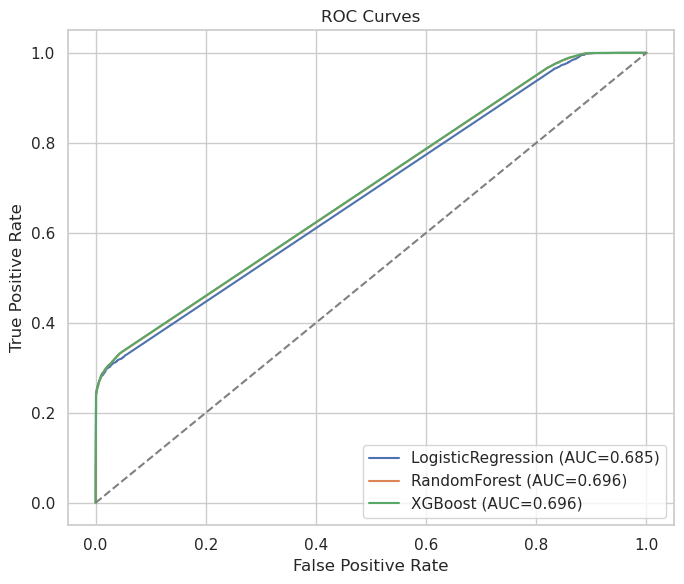

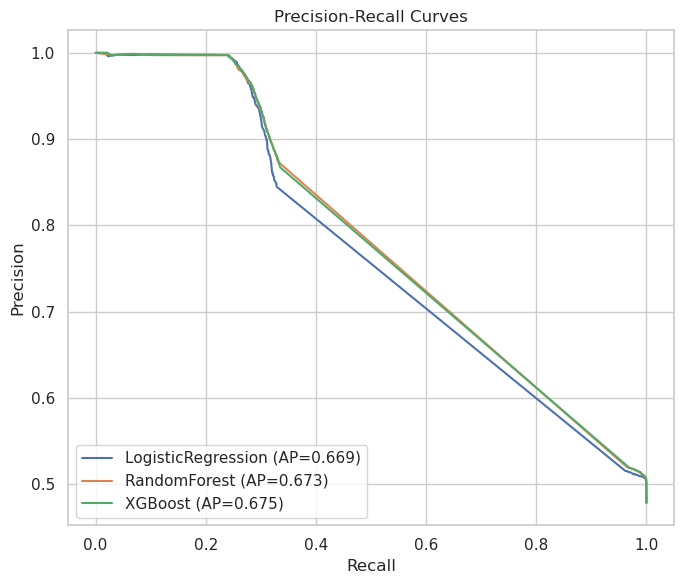

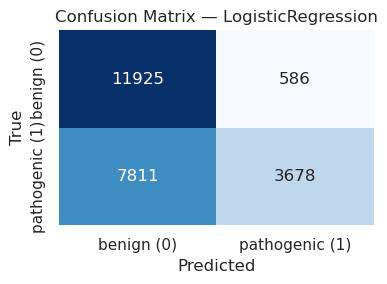

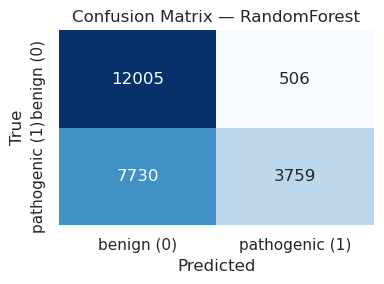

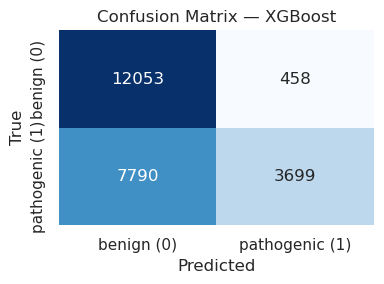

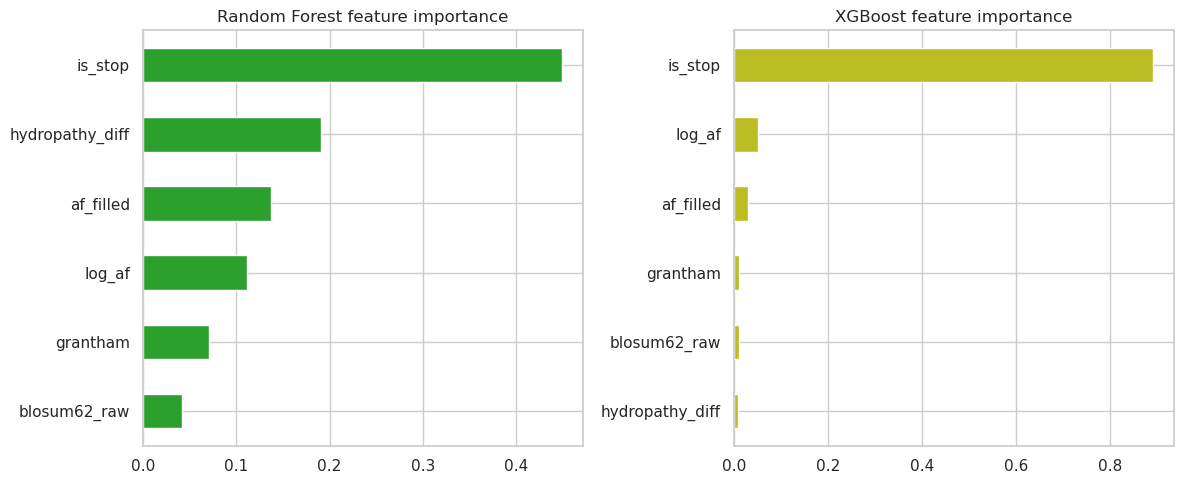

Saved feature importances to /mnt/c/Users/MYG-D02/variant-effect-prediction/results/feature_importances.png

All outputs saved to: /mnt/c/Users/MYG-D02/variant-effect-prediction/results


In [6]:
# TRAIN + EVAL PIPELINE — save outputs to Windows-mounted results folder
# Paste into your notebook and run.
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
sns.set(style="whitegrid")

# ---------------- CONFIG ----------------
CSV_PATH = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/data/processed/clinvar_features_engineered.csv")
OUT_DIR = Path("/mnt/c/Users/MYG-D02/variant-effect-prediction/results")
OUT_DIR.mkdir(parents=True, exist_ok=True)
RANDOM_STATE = 42
TEST_SIZE = 0.2
# If your dataset is huge and causes memory issues, set SAMPLE_FOR_TRAIN to an integer (e.g. 120000).
# Otherwise set to None to use all available rows (may be heavy).
SAMPLE_FOR_TRAIN = 120000  # set None to use all rows

# ---------------- LOAD ----------------
print("Loading:", CSV_PATH)
df = pd.read_csv(CSV_PATH, low_memory=False)
print("Loaded shape:", df.shape)
print("Columns:", list(df.columns))

# ---------------- FEATURES + LABEL ----------------
FEATURES = ["blosum62_raw","hydropathy_diff","is_stop","grantham","af_filled","log_af"]
# ensure log_af exists: create from af_filled if necessary
if "af_filled" not in df.columns and "allele_freq" in df.columns:
    df["af_filled"] = pd.to_numeric(df["allele_freq"], errors="coerce").fillna(0.0)
if "af_filled" not in df.columns:
    df["af_filled"] = 0.0
if "log_af" not in df.columns:
    df["log_af"] = np.log10(df["af_filled"].clip(lower=1e-12))

missing = [c for c in FEATURES if c not in df.columns]
if missing:
    raise RuntimeError(f"Missing required features in CSV: {missing}")

# ensure numeric
for c in FEATURES:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# label
if "label_numeric" in df.columns:
    df["label_numeric"] = pd.to_numeric(df["label_numeric"], errors="coerce")
elif "label" in df.columns:
    df["label_numeric"] = df["label"].astype(str).str.lower().map({"benign":0,"pathogenic":1})
else:
    raise RuntimeError("No label found. Need label_numeric or label column.")

# drop rows without label
df = df[df["label_numeric"].notna()].copy()
df["label_numeric"] = df["label_numeric"].astype(int)

# ---------------- Sample (optional) ----------------
if SAMPLE_FOR_TRAIN is not None and SAMPLE_FOR_TRAIN < len(df):
    df = df.sample(n=SAMPLE_FOR_TRAIN, random_state=RANDOM_STATE)
    print("Downsampled for training to:", df.shape)

# ---------------- Prepare X, y ----------------
X = df[FEATURES].copy()
y = df["label_numeric"].copy()

# Remove rows with all-NaN features (but keep rows with some NaNs: we'll impute later)
mask_any = X.notna().any(axis=1)
X = X.loc[mask_any]
y = y.loc[mask_any]
print("Rows with (any) feature data:", X.shape[0])

# ---------------- Train/test split (stratified) ----------------
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# ---------------- Preprocessing: median impute for missing, StandardScaler for LR ----------------
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy="median")
imputer.fit(X_train_raw)
X_train_imp = pd.DataFrame(imputer.transform(X_train_raw), columns=FEATURES, index=X_train_raw.index)
X_test_imp  = pd.DataFrame(imputer.transform(X_test_raw), columns=FEATURES, index=X_test_raw.index)

scaler = StandardScaler()
scaler.fit(X_train_imp)   # fit scaler on imputed numeric features
X_train_scaled = pd.DataFrame(scaler.transform(X_train_imp), columns=FEATURES, index=X_train_imp.index)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test_imp), columns=FEATURES, index=X_test_imp.index)

# save preprocessing objects
joblib.dump(imputer, OUT_DIR / "imputer.pkl")
joblib.dump(scaler, OUT_DIR / "scaler.pkl")
print("Saved preprocessing to:", OUT_DIR)

# ---------------- Models ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
try:
    from xgboost import XGBClassifier
except Exception:
    XGBClassifier = None
    print("Warning: xgboost not installed. XGBoost model will be skipped.")

models = {}
models["LogisticRegression"] = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=RANDOM_STATE)
models["RandomForest"] = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1)
if XGBClassifier is not None:
    models["XGBoost"] = XGBClassifier(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.8,
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric="logloss"
    )

# Fit models (LR uses scaled data; tree models use imputed-unscaled for interpretability)
print("\nTraining models...")
models["LogisticRegression"].fit(X_train_scaled, y_train)
models["RandomForest"].fit(X_train_imp, y_train)
if "XGBoost" in models:
    models["XGBoost"].fit(X_train_imp, y_train)

# Save models
for name, m in models.items():
    fn = OUT_DIR / f"{name.lower()}.pkl"
    joblib.dump(m, fn)
    print("Saved model:", fn)

# ---------------- EVALUATION helpers ----------------
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report

def plot_and_save_roc(models_dict, X_test_for_model, y_test_vals, out_fn):
    plt.figure(figsize=(7,6))
    for name, m in models_dict.items():
        if hasattr(m, "predict_proba"):
            probs = m.predict_proba(X_test_for_model[name])[:,1]
        else:
            # fallback: decision_function or predict
            try:
                probs = m.decision_function(X_test_for_model[name])
            except:
                probs = m.predict(X_test_for_model[name])
        fpr, tpr, _ = roc_curve(y_test_vals, probs)
        auc = roc_auc_score(y_test_vals, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0,1],[0,1], linestyle="--", color="grey")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig(out_fn, dpi=150)
    plt.show()

def plot_and_save_pr(models_dict, X_test_for_model, y_test_vals, out_fn):
    plt.figure(figsize=(7,6))
    for name, m in models_dict.items():
        if hasattr(m, "predict_proba"):
            probs = m.predict_proba(X_test_for_model[name])[:,1]
        else:
            try:
                probs = m.decision_function(X_test_for_model[name])
            except:
                probs = m.predict(X_test_for_model[name])
        prec, rec, _ = precision_recall_curve(y_test_vals, probs)
        ap = average_precision_score(y_test_vals, probs)
        plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curves")
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig(out_fn, dpi=150)
    plt.show()

def plot_and_save_cm(y_true, y_pred, labels, out_fn, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", ax=ax, cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.savefig(out_fn, dpi=150)
    plt.show()

# Prepare test inputs for each model (scaled for LR, imputed for trees)
X_test_for_model = {
    "LogisticRegression": X_test_scaled,
    "RandomForest": X_test_imp.loc[X_test_imp.index],
}
if "XGBoost" in models:
    X_test_for_model["XGBoost"] = X_test_imp.loc[X_test_imp.index]

# ---------------- Compute metrics + plots ----------------
metrics_summary = []
for name, m in models.items():
    X_input = X_test_for_model[name]
    if hasattr(m, "predict_proba"):
        probs = m.predict_proba(X_input)[:,1]
    else:
        try:
            probs = m.decision_function(X_input)
        except:
            probs = m.predict(X_input)
    preds = (probs >= 0.5).astype(int)
    auc = roc_auc_score(y_test, probs)
    ap = average_precision_score(y_test, probs)
    acc = (preds == y_test).mean()
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    cm = confusion_matrix(y_test, preds)
    metrics_summary.append({
        "model": name,
        "acc": acc,
        "prec": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc,
        "ap": ap
    })
    print(f"\n--- {name} ---")
    print(f"AUC={auc:.3f}, AP={ap:.3f}, ACC={acc:.3f}, PREC={prec:.3f}, RECALL={rec:.3f}, F1={f1:.3f}")
    print("Confusion matrix:\n", cm)
    print("Classification report:\n", classification_report(y_test, preds, digits=3, zero_division=0))

# Save metrics table
metrics_df = pd.DataFrame(metrics_summary).set_index("model")
metrics_df.to_csv(OUT_DIR / "model_metrics_summary.csv")
print("\nSaved metrics table to", OUT_DIR / "model_metrics_summary.csv")
display(metrics_df)

# Plot ROC and PR curves (combined)
plot_and_save_roc(models, X_test_for_model, y_test, OUT_DIR / "roc_curves.png")
plot_and_save_pr(models, X_test_for_model, y_test, OUT_DIR / "pr_curves.png")

# Confusion matrices (one per model)
for name, m in models.items():
    X_input = X_test_for_model[name]
    if hasattr(m, "predict_proba"):
        probs = m.predict_proba(X_input)[:,1]
    else:
        try:
            probs = m.decision_function(X_input)
        except:
            probs = m.predict(X_input)
    preds = (probs >= 0.5).astype(int)
    plot_and_save_cm(y_test, preds, labels=["benign (0)","pathogenic (1)"], out_fn=OUT_DIR / f"confusion_{name}.png", title=f"Confusion Matrix — {name}")

# ---------------- Feature importances (RF + XGB) ----------------
# Create a clean importance plot showing both RF and XGBoost (if present)
fig, axes = plt.subplots(1,2, figsize=(12,5))
# RF
rf = models["RandomForest"]
imp_rf = pd.Series(rf.feature_importances_, index=FEATURES).sort_values()
imp_rf.plot(kind="barh", ax=axes[0], color="tab:green")
axes[0].set_title("Random Forest feature importance")
# XGB
if "XGBoost" in models:
    xg = models["XGBoost"]
    imp_xg = pd.Series(xg.feature_importances_, index=FEATURES).sort_values()
    imp_xg.plot(kind="barh", ax=axes[1], color="tab:olive")
    axes[1].set_title("XGBoost feature importance")
else:
    axes[1].axis("off")
plt.tight_layout()
plt.savefig(OUT_DIR / "feature_importances.png", dpi=150)
plt.show()
print("Saved feature importances to", OUT_DIR / "feature_importances.png")

print("\nAll outputs saved to:", OUT_DIR)
